# T2D Microbiome Project
## Research Question
Can gut microbiome profiles distinguish **T2D** from **non-T2D**, and which taxonomic representation is most reliable for prediction?


## Abstract
In this notebook we test whether gut microbiome profiles can separate **T2D** from **non-T2D** in our cohort.
We follow a full course-aligned pipeline: leakage-safe preprocessing, TAXA-level comparison, classical ML models, a taxonomy-aware CNN baseline, unsupervised visualization, statistical testing, multiple-testing correction, and explainability.


## Introduction
Our project question is practical: can microbiome composition help classify T2D, and at which taxonomic representation does performance look most reliable?

Because this dataset is sparse and high-dimensional, we keep the hierarchy explicit (species/genus/subPCA), compare multiple models, and then check both predictive quality and biological interpretability.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import shap

from scipy.stats import mannwhitneyu, ttest_ind, ttest_rel, wilcoxon
from statsmodels.stats.multitest import multipletests

from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [3]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sns.set_theme(style='whitegrid')
print('device:', DEVICE)


device: cpu


## 1. Load Data


In [4]:
df = pd.read_csv('T2D_microbiome_dataset.csv')
X_raw = df.drop(columns=['label'])
y_multi = df['label']
y = (y_multi == 'T2D').astype(int)


In [5]:
print('shape:', df.shape)
print('labels:', y_multi.value_counts().to_dict())
print('binary:', y.value_counts().to_dict())


shape: (145, 499)
labels: {'T2D': 53, 'IGT': 49, 'healthy': 43}
binary: {0: 92, 1: 53}


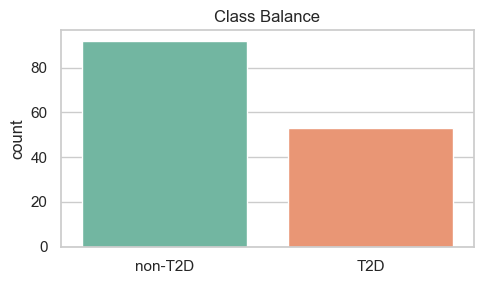

In [6]:
plt.figure(figsize=(5,3))
sns.countplot(x=np.where(y==1,'T2D','non-T2D'), palette='Set2')
plt.title('Class Balance')
plt.tight_layout(); plt.show()


## 1.1 Raw Bacterial Distribution Diagnostics


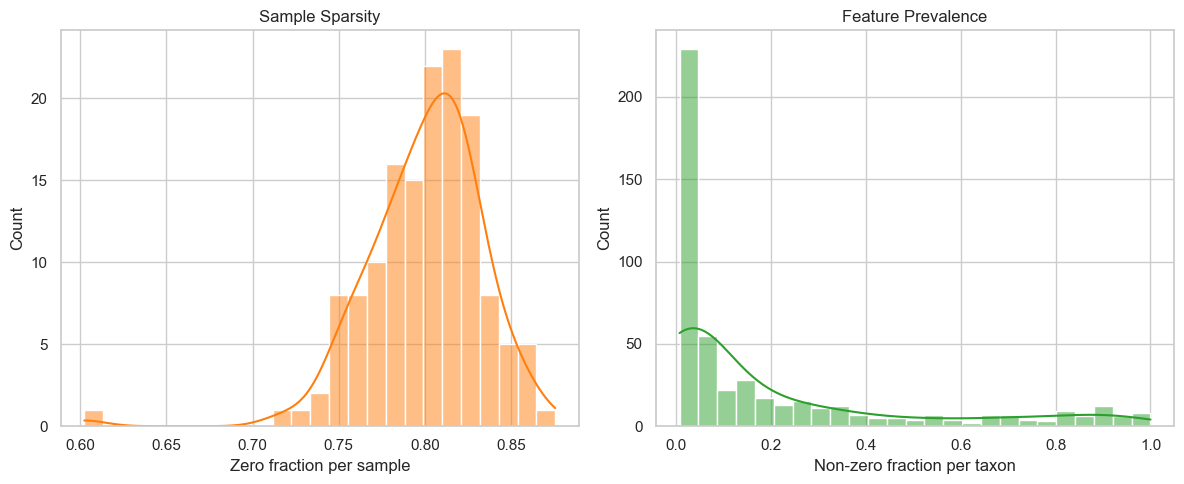

In [8]:
row_sums = X_raw.sum(axis=1)
sample_zero_fraction = (X_raw == 0).mean(axis=1)
feature_prevalence = (X_raw > 0).mean(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(sample_zero_fraction, bins=25, kde=True, ax=axes[0], color='#ff7f0e')
axes[0].set_title('Sample Sparsity')
axes[0].set_xlabel('Zero fraction per sample')

sns.histplot(feature_prevalence, bins=25, kde=True, ax=axes[1], color='#2ca02c')
axes[1].set_title('Feature Prevalence')
axes[1].set_xlabel('Non-zero fraction per taxon')

plt.tight_layout()
plt.show()
plt.show()


#

These three plots explain *why* we preprocess:
- high sparsity supports prevalence filtering,
- skewed abundances support log transform,
- prevalence spread supports taxonomy-aware reduction.


## 2. Preprocessing (each step separated)


### 2.1 Train/Test Split


In [9]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, stratify=y, random_state=SEED
)
print(X_train_raw.shape, X_test_raw.shape)


(116, 498) (29, 498)


### 2.2 Prevalence Filter (fit on train only)


In [10]:
prev_thr = 0.10
prevalence = (X_train_raw > 0).mean(axis=0)
keep_cols = prevalence[prevalence >= prev_thr].index.tolist()


In [11]:
X_train_f = X_train_raw[keep_cols].copy()
X_test_f = X_test_raw[keep_cols].copy()
print('features before/after:', X_train_raw.shape[1], X_train_f.shape[1])


features before/after: 498 209


### 2.3 Taxonomy Parsing + MIPMLP Aggregation


In [12]:
def parse_genus(col):
    if col.startswith('genus:'):
        return col.split(':',1)[1].strip()
    if col.startswith('species:'):
        return col.split(':',1)[1].strip().split(' ')[0].strip('[]')
    return col


def agg_genus(df_in):
    m = pd.Series({c: parse_genus(c) for c in df_in.columns})
    return df_in.T.groupby(m).sum().T


In [13]:
X_train_genus_raw = agg_genus(X_train_f)
X_test_genus_raw = agg_genus(X_test_f)
print('species shape:', X_train_f.shape, 'genus shape:', X_train_genus_raw.shape)


species shape: (116, 209) genus shape: (116, 94)


### 2.4 Log Transform


### 2.4.1 Bacterial Distribution Before Log Transform


Pre-log non-zero count: 10628
Pre-log zero fraction: 0.5616


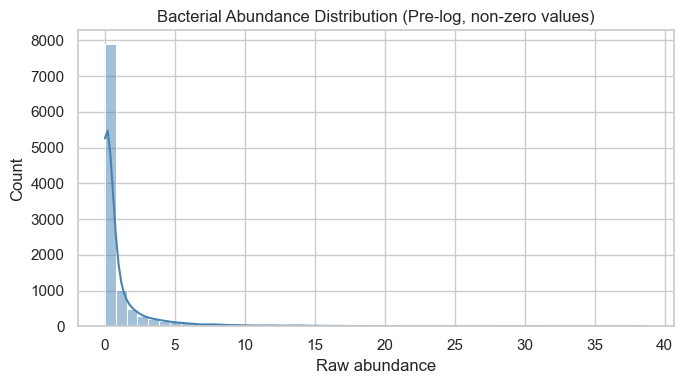

In [16]:
raw_vals = X_train_f.to_numpy().ravel()
raw_nonzero = raw_vals[raw_vals > 0]

print('Pre-log non-zero count:', raw_nonzero.size)
print('Pre-log zero fraction:', round(float((raw_vals == 0).mean()), 4))

plt.figure(figsize=(7, 4))
sns.histplot(raw_nonzero, bins=50, kde=True, color='steelblue')
plt.title('Bacterial Abundance Distribution (Pre-log, non-zero values)')
plt.xlabel('Raw abundance')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [17]:
X_train_species = np.log1p(X_train_f)
X_test_species = np.log1p(X_test_f)

### 2.4.2 Bacterial Distribution After Log Transform


Post-log non-zero count: 10628


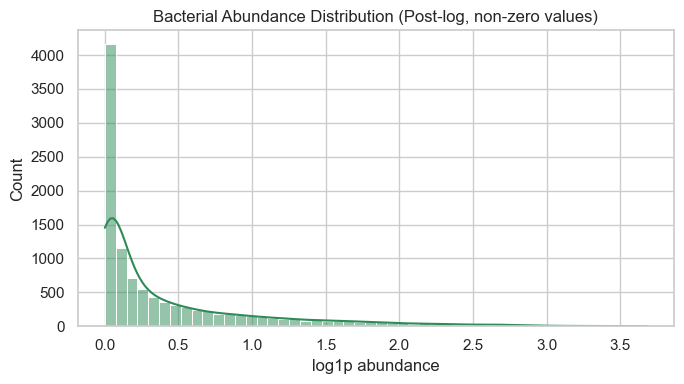

In [18]:
log_vals = X_train_species.to_numpy().ravel()
log_nonzero = log_vals[log_vals > 0]

print('Post-log non-zero count:', log_nonzero.size)

plt.figure(figsize=(7, 4))
sns.histplot(log_nonzero, bins=50, kde=True, color='seagreen')
plt.title('Bacterial Abundance Distribution (Post-log, non-zero values)')
plt.xlabel('log1p abundance')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


### 2.4.3 Pre vs Post Log (Normality-Like Shape Check)


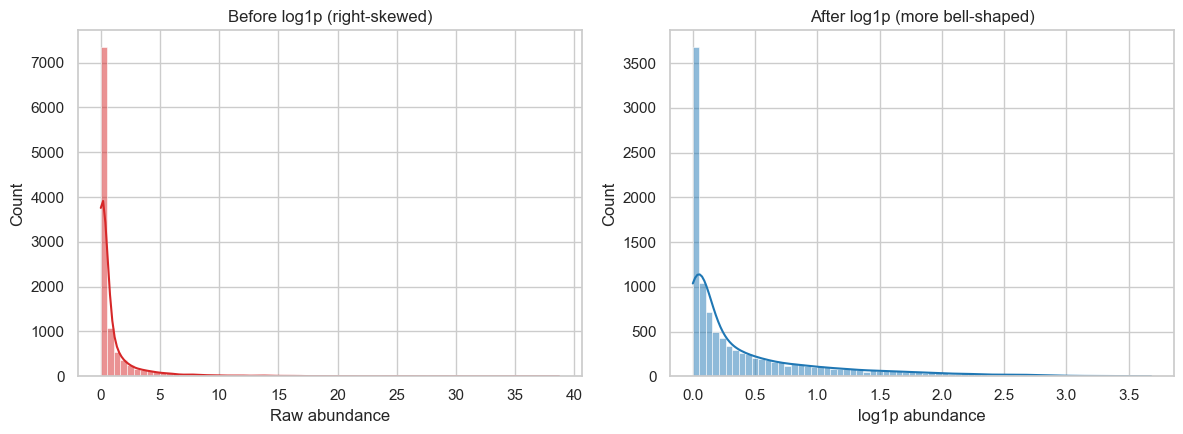

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=False)

sns.histplot(raw_nonzero, bins=70, kde=True, ax=axes[0], color='#d62728')
axes[0].set_title('Before log1p (right-skewed)')
axes[0].set_xlabel('Raw abundance')

sns.histplot(log_nonzero, bins=70, kde=True, ax=axes[1], color='#1f77b4')
axes[1].set_title('After log1p (more bell-shaped)')
axes[1].set_xlabel('log1p abundance')

plt.tight_layout()
plt.show()


In [20]:
X_train_genus = np.log1p(X_train_genus_raw)
X_test_genus = np.log1p(X_test_genus_raw)


### 2.5 Z-Score (for linear/unsupervised steps)


In [21]:
sp_scaler = StandardScaler().fit(X_train_species)
X_train_species_z = pd.DataFrame(sp_scaler.transform(X_train_species), index=X_train_species.index, columns=X_train_species.columns)
X_test_species_z = pd.DataFrame(sp_scaler.transform(X_test_species), index=X_test_species.index, columns=X_test_species.columns)


### 2.6 SubPCA (MIPMLP-inspired)


In [22]:
class SubPCA:
    def __init__(self, min_k=2, seed=42):
        self.min_k=min_k; self.seed=seed; self.groups={}; self.single=[]
    def fit(self, X):
        gm = pd.Series({c: parse_genus(c) for c in X.columns})
        for g, cols in gm.groupby(gm).groups.items():
            cols=list(cols)
            if len(cols)>=self.min_k:
                p=PCA(n_components=1, random_state=self.seed).fit(X[cols])
                self.groups[g]=(cols,p)
            else:
                self.single.extend(cols)
        return self
    def transform(self, X):
        out={}
        for g,(cols,p) in sorted(self.groups.items()):
            out[f'subpca:{g}']=p.transform(X[cols]).ravel()
        for c in self.single:
            out[c]=X[c].values
        return pd.DataFrame(out,index=X.index)


In [23]:
subpca = SubPCA(min_k=2, seed=SEED).fit(X_train_species)
X_train_sub = subpca.transform(X_train_species)
X_test_sub = subpca.transform(X_test_species)
print('subPCA shape:', X_train_sub.shape)


subPCA shape: (116, 94)


## 3. TAXA-Level Selection (Species / Genus / SubPCA)


In [24]:
repr_train = {'species': X_train_species, 'genus': X_train_genus, 'subpca': X_train_sub}
repr_test = {'species': X_test_species, 'genus': X_test_genus, 'subpca': X_test_sub}


In [25]:
rows=[]
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for level, Xl in repr_train.items():
    pipe=Pipeline([('sc',StandardScaler()),('lr',LogisticRegression(max_iter=3000,class_weight='balanced'))])
    s=cross_validate(pipe, Xl, y_train, cv=cv, scoring='roc_auc', n_jobs=1)['test_score']
    rows.append({'taxa_level':level,'cv_auc_mean':s.mean(),'cv_auc_std':s.std(),'n_features':Xl.shape[1]})
level_df=pd.DataFrame(rows).sort_values('cv_auc_mean',ascending=False)
display(level_df.round(4))


,taxa_level,cv_auc_mean,cv_auc_std,n_features
0,species,0.5020,0.1235,209
2,subpca,0.4887,0.0997,94
1,genus,0.4840,0.0560,94


In [26]:
best = level_df.iloc[0]
best_level = best['taxa_level']
X_train_sel = repr_train[best_level]
X_test_sel = repr_test[best_level]

print(f"Chosen TAXA level: {best_level.upper()}")
print(f"Why: best CV AUC = {best['cv_auc_mean']:.3f} +/- {best['cv_auc_std']:.3f}, with {int(best['n_features'])} features.")
print('Dataset limitation: only species + few genus columns are provided, so higher levels (Kingdom->Family) are not directly available.')


Chosen TAXA level: SPECIES
Why: best CV AUC = 0.502 +/- 0.123, with 209 features.
Dataset limitation: only species + few genus columns are provided, so higher levels (Kingdom->Family) are not directly available.


## 4. Unsupervised Separation (PCA and PCoA)


In [27]:
X_full_f = X_raw[keep_cols]
X_full_species = np.log1p(X_full_f)
X_full_genus = np.log1p(agg_genus(X_full_f))
X_full_sub = subpca.transform(X_full_species)
repr_full = {'species': X_full_species, 'genus': X_full_genus, 'subpca': X_full_sub}
X_full_sel = repr_full[best_level]
y_full = y.loc[X_full_sel.index]


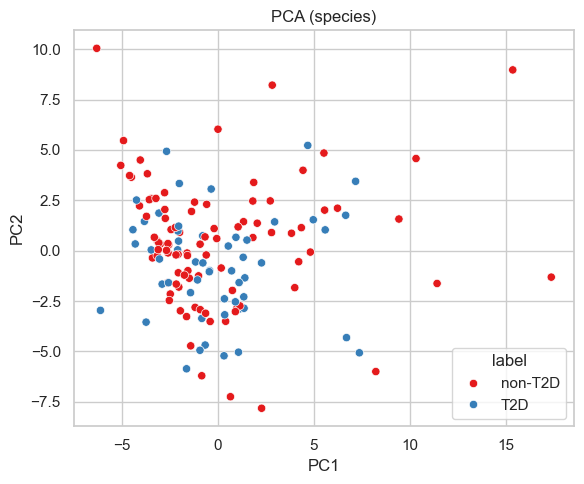

In [28]:
pc = PCA(n_components=2, random_state=SEED).fit_transform(StandardScaler().fit_transform(X_full_sel))
pca_df = pd.DataFrame(pc, columns=['PC1','PC2'])
pca_df['label']=np.where(y_full==1,'T2D','non-T2D')

plt.figure(figsize=(6,5))
sns.scatterplot(data=pca_df,x='PC1',y='PC2',hue='label',palette='Set1')
plt.title(f'PCA ({best_level})'); plt.tight_layout(); plt.show()


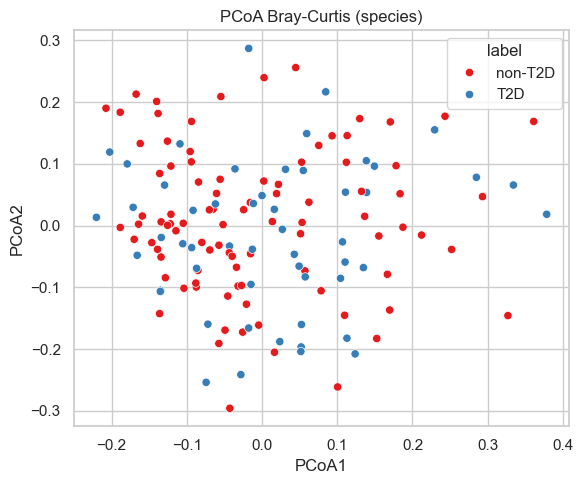

In [29]:
def pcoa(D, k=2):
    n=D.shape[0]
    J=np.eye(n)-np.ones((n,n))/n
    B=-0.5*J@(D**2)@J
    w,v=np.linalg.eigh(B)
    idx=np.argsort(w)[::-1]
    w=np.clip(w[idx],0,None)
    v=v[:,idx]
    return v[:,:k]*np.sqrt(w[:k])

D = pairwise_distances(X_full_sel, metric='braycurtis')
co = pcoa(D,2)
pco_df = pd.DataFrame(co, columns=['PCoA1','PCoA2'])
pco_df['label']=np.where(y_full==1,'T2D','non-T2D')

plt.figure(figsize=(6,5))
sns.scatterplot(data=pco_df,x='PCoA1',y='PCoA2',hue='label',palette='Set1')
plt.title(f'PCoA Bray-Curtis ({best_level})'); plt.tight_layout(); plt.show()


## 5. Model Comparison (RF, XGBoost/fallback, Taxonomy-CNN)


In [30]:
def y_prob(model, X):
    if hasattr(model,'predict_proba'):
        return model.predict_proba(X)[:,1]
    s=model.decision_function(X)
    return (s-s.min())/(s.max()-s.min()+1e-9)

def metric_row(y_true, prob):
    pred=(prob>=0.5).astype(int)
    return {
        'accuracy':accuracy_score(y_true,pred),
        'auc_roc':roc_auc_score(y_true,prob),
        'f1':f1_score(y_true,pred),
        'precision':precision_score(y_true,pred,zero_division=0),
        'recall':recall_score(y_true,pred,zero_division=0),
        'pr_auc':average_precision_score(y_true,prob),
    }


In [31]:
rf = RandomForestClassifier(n_estimators=500,min_samples_leaf=2,class_weight='balanced',random_state=SEED)
try:
    from xgboost import XGBClassifier
    gb = XGBClassifier(n_estimators=400,max_depth=4,learning_rate=0.05,subsample=0.9,colsample_bytree=0.9,objective='binary:logistic',eval_metric='auc',random_state=SEED)
    gb_name='XGBoost'
except Exception:
    gb = GradientBoostingClassifier(random_state=SEED)
    gb_name='Gradient Boosting (XGBoost fallback)'
print('boosting model:', gb_name)


boosting model: Gradient Boosting (XGBoost fallback)


In [32]:
models={'Random Forest':rf, gb_name:gb}
trained={}
probs={}
rows=[]
for n,m in models.items():
    m.fit(X_train_sel,y_train)
    p=y_prob(m,X_test_sel)
    trained[n]=m; probs[n]=p
    rows.append({'model':n,'representation':best_level,**metric_row(y_test,p)})
tab_df=pd.DataFrame(rows).sort_values('auc_roc',ascending=False)
display(tab_df.round(3))


,model,representation,accuracy,auc_roc,f1,precision,recall,pr_auc
1,Gradient Boosting (XGBoost fallback),species,0.621,0.722,0.353,0.5,0.273,0.563
0,Random Forest,species,0.621,0.682,0.154,0.5,0.091,0.517


### 5.1 Grid Search for Tabular Models (printed in notebook)


In [33]:
cv_grid = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

rf_param_grid = {
    'n_estimators': [200, 500, 800],
    'max_depth': [None, 6, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=SEED),
    param_grid=rf_param_grid,
    scoring='roc_auc',
    cv=cv_grid,
    n_jobs=1,
    refit=True,
    return_train_score=True,
)
rf_grid.fit(X_train_sel, y_train)

rf_grid_df = pd.DataFrame(rf_grid.cv_results_).sort_values('rank_test_score')
display(rf_grid_df[['params','mean_test_score','std_test_score','rank_test_score']].head(12))
print('RF best params:', rf_grid.best_params_)
print('RF best CV AUC:', round(float(rf_grid.best_score_), 4))

if gb_name == 'XGBoost':
    from xgboost import XGBClassifier

    boost_est = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=SEED,
    )
    boost_param_grid = {
        'n_estimators': [200, 400],
        'max_depth': [3, 4, 6],
        'learning_rate': [0.03, 0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
    }
else:
    boost_est = GradientBoostingClassifier(random_state=SEED)
    boost_param_grid = {
        'n_estimators': [100, 200, 400],
        'learning_rate': [0.03, 0.05, 0.1],
        'max_depth': [2, 3, 4],
        'min_samples_leaf': [1, 2, 4],
    }

boost_grid = GridSearchCV(
    estimator=boost_est,
    param_grid=boost_param_grid,
    scoring='roc_auc',
    cv=cv_grid,
    n_jobs=1,
    refit=True,
    return_train_score=True,
)
boost_grid.fit(X_train_sel, y_train)

boost_grid_df = pd.DataFrame(boost_grid.cv_results_).sort_values('rank_test_score')
display(boost_grid_df[['params','mean_test_score','std_test_score','rank_test_score']].head(12))
print(f'{gb_name} best params:', boost_grid.best_params_)
print(f'{gb_name} best CV AUC:', round(float(boost_grid.best_score_), 4))


,params,mean_test_score,std_test_score,rank_test_score
22,"{'max_depth': 10, 'min_samples_leaf': 2, 'n_es...",0.569206,0.120534,1
4,"{'max_depth': None, 'min_samples_leaf': 2, 'n_...",0.567619,0.118969,2
25,"{'max_depth': 10, 'min_samples_leaf': 4, 'n_es...",0.564048,0.098843,3
7,"{'max_depth': None, 'min_samples_leaf': 4, 'n_...",0.564048,0.098843,3
3,"{'max_depth': None, 'min_samples_leaf': 2, 'n_...",0.561931,0.120378,5
21,"{'max_depth': 10, 'min_samples_leaf': 2, 'n_es...",0.561931,0.120378,5
14,"{'max_depth': 6, 'min_samples_leaf': 2, 'n_est...",0.557143,0.091209,7
17,"{'max_depth': 6, 'min_samples_leaf': 4, 'n_est...",0.556376,0.090083,8
8,"{'max_depth': None, 'min_samples_leaf': 4, 'n_...",0.555635,0.096170,9
26,"{'max_depth': 10, 'min_samples_leaf': 4, 'n_es...",0.555635,0.096170,9


RF best params: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 500}
RF best CV AUC: 0.5692


,params,mean_test_score,std_test_score,rank_test_score
29,"{'learning_rate': 0.05, 'max_depth': 2, 'min_s...",0.546799,0.039828,1
12,"{'learning_rate': 0.03, 'max_depth': 3, 'min_s...",0.531402,0.123734,2
28,"{'learning_rate': 0.05, 'max_depth': 2, 'min_s...",0.527116,0.058017,3
48,"{'learning_rate': 0.05, 'max_depth': 4, 'min_s...",0.526085,0.130073,4
18,"{'learning_rate': 0.03, 'max_depth': 4, 'min_s...",0.524947,0.112962,5
2,"{'learning_rate': 0.03, 'max_depth': 2, 'min_s...",0.524947,0.063463,5
45,"{'learning_rate': 0.05, 'max_depth': 4, 'min_s...",0.523810,0.123146,7
1,"{'learning_rate': 0.03, 'max_depth': 2, 'min_s...",0.522910,0.073013,8
7,"{'learning_rate': 0.03, 'max_depth': 2, 'min_s...",0.522090,0.084007,9
33,"{'learning_rate': 0.05, 'max_depth': 2, 'min_s...",0.522090,0.091599,9


Gradient Boosting (XGBoost fallback) best params: {'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 400}
Gradient Boosting (XGBoost fallback) best CV AUC: 0.5468


In [43]:
models = {
    'Random Forest (tuned)': rf_grid.best_estimator_,
    f'{gb_name} (tuned)': boost_grid.best_estimator_,
}

trained = {}
probs = {}
rows = []

for n, m in models.items():
    m.fit(X_train_sel, y_train)
    p = y_prob(m, X_test_sel)
    trained[n] = m
    probs[n] = p
    rows.append({'model': n, 'representation': best_level, **metric_row(y_test, p)})

tab_df = pd.DataFrame(rows).sort_values('auc_roc', ascending=False)
display(tab_df.round(3))


,model,representation,accuracy,auc_roc,f1,precision,recall,pr_auc
0,Random Forest (tuned),species,0.621,0.682,0.154,0.5,0.091,0.517
1,Gradient Boosting (XGBoost fallback) (tuned),species,0.586,0.657,0.250,0.4,0.182,0.508


### 5.2 Taxonomy-aware CNN (species table -> genus-ordered image)


In [62]:
cols_img = sorted(X_train_species.columns, key=lambda c:(parse_genus(c),c))
side = int(np.ceil(np.sqrt(len(cols_img))))

def to_img(X):
    A=X[cols_img].to_numpy(dtype=np.float32)
    pad=side*side-A.shape[1]
    if pad>0: A=np.pad(A,((0,0),(0,pad)))
    return A.reshape(A.shape[0],1,side,side)

Xi_tr, Xi_te = to_img(X_train_species), to_img(X_test_species)
print('image shape:', Xi_tr.shape)


image shape: (116, 1, 15, 15)


In [63]:
class TinyCNN(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.f=nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4,4)),
        )
        self.h=nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*4*4,64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64,1),
        )

    def forward(self,x):
        return self.h(self.f(x)).squeeze(1)


In [64]:
def train_cnn(Xtr, ytr, Xte, yte, epochs=80, bs=16, lr=1e-3, pat=12, dropout=0.3):
    Xa, Xv, ya, yv = train_test_split(Xtr, ytr.to_numpy(dtype=np.float32), test_size=0.2, stratify=ytr, random_state=SEED)
    
    dl = DataLoader(TensorDataset(torch.tensor(Xa, dtype=torch.float32), torch.tensor(ya, dtype=torch.float32)), batch_size=bs, shuffle=True)
    
    Xv = torch.tensor(Xv, dtype=torch.float32, device=DEVICE)
    yv = torch.tensor(yv, dtype=torch.float32, device=DEVICE)
    Xte = torch.tensor(Xte, dtype=torch.float32, device=DEVICE)

    m = TinyCNN(dropout=dropout).to(DEVICE)
    pos = max(ya.sum(), 1)
    neg = len(ya) - ya.sum()
    
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([float(neg/pos)], dtype=torch.float32, device=DEVICE))
    opt = torch.optim.Adam(m.parameters(), lr=lr)

    best, bv, wait = None, np.inf, 0
    for _ in range(epochs):
        m.train()
        for xb, yb in dl:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            opt.zero_grad()
            loss = loss_fn(m(xb), yb)
            loss.backward()
            opt.step()

        m.eval()
        with torch.no_grad():
            v = loss_fn(m(Xv), yv).item()

        if v < bv - 1e-4:
            bv = v
            wait = 0
            best = {k: v.detach().cpu().clone() for k, v in m.state_dict().items()}
        else:
            wait += 1
            if wait >= pat:
                break

    if best is not None:
        m.load_state_dict(best)

    m.eval()
    with torch.no_grad():
            p = np.array(torch.sigmoid(m(Xte)).cpu().tolist())

    return m, p, bv

### 5.3 Grid Search for CNN (printed in notebook)


In [65]:
cnn_search_space = [
    {'lr': 1e-3, 'bs': 16, 'dropout': 0.3},
    {'lr': 5e-4, 'bs': 16, 'dropout': 0.3},
    {'lr': 1e-3, 'bs': 32, 'dropout': 0.3},
    {'lr': 1e-3, 'bs': 16, 'dropout': 0.5},
]

cnn_grid_rows = []
for cfg in cnn_search_space:
    _, p_tmp, val_loss = train_cnn(
        Xi_tr,
        y_train,
        Xi_te,
        y_test,
        epochs=70,
        bs=cfg['bs'],
        lr=cfg['lr'],
        pat=10,
        dropout=cfg['dropout'],
    )
    cnn_grid_rows.append(
        {
            **cfg,
            'val_loss': float(val_loss),
            **metric_row(y_test, p_tmp),
        }
    )

cnn_grid_df = pd.DataFrame(cnn_grid_rows).sort_values('val_loss', ascending=True)
display(cnn_grid_df.round(4))

best_cnn_cfg = cnn_grid_df.iloc[0][['lr','bs','dropout']].to_dict()
best_cnn_cfg['bs'] = int(best_cnn_cfg['bs'])
print('Best CNN config by validation loss:', best_cnn_cfg)


,lr,bs,dropout,val_loss,accuracy,auc_roc,f1,precision,recall,pr_auc
0,0.0010,16,0.3,0.8474,0.4483,0.3889,0.4667,0.3684,0.6364,0.3948
3,0.0010,16,0.5,0.8562,0.3448,0.3182,0.3448,0.2778,0.4545,0.3725
1,0.0005,16,0.3,0.8562,0.3103,0.2778,0.2308,0.2000,0.2727,0.3597
2,0.0010,32,0.3,0.8691,0.4138,0.3182,0.4138,0.3333,0.5455,0.3714


Best CNN config by validation loss: {'lr': 0.001, 'bs': 16, 'dropout': 0.3}


In [66]:
cnn, p_cnn, cnn_val_loss = train_cnn(
    Xi_tr,
    y_train,
    Xi_te,
    y_test,
    epochs=80,
    bs=best_cnn_cfg['bs'],
    lr=best_cnn_cfg['lr'],
    pat=12,
    dropout=best_cnn_cfg['dropout'],
)

cnn_df = pd.DataFrame([
    {
        'model':'Taxonomy-CNN',
        'representation':'species->image(genus-ordered)',
        **metric_row(y_test,p_cnn),
    }
])

results_df = pd.concat([tab_df,cnn_df],ignore_index=True).sort_values('auc_roc',ascending=False)
display(results_df.round(3))
print('Selected CNN config:', best_cnn_cfg, '| val_loss:', round(float(cnn_val_loss), 4))


,model,representation,accuracy,auc_roc,f1,precision,recall,pr_auc
0,Random Forest (tuned),species,0.621,0.682,0.154,0.500,0.091,0.517
1,Gradient Boosting (XGBoost fallback) (tuned),species,0.586,0.657,0.250,0.400,0.182,0.508
2,Taxonomy-CNN,species->image(genus-ordered),0.310,0.359,0.333,0.263,0.455,0.388


Selected CNN config: {'lr': 0.001, 'bs': 16, 'dropout': 0.3} | val_loss: 0.8462


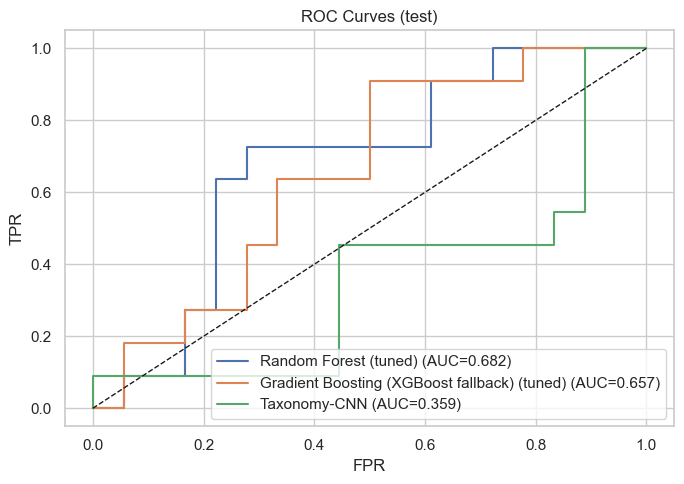

In [67]:
all_probs=dict(probs); all_probs['Taxonomy-CNN']=p_cnn

plt.figure(figsize=(7,5))
for n,p in all_probs.items():
    fpr,tpr,_=roc_curve(y_test,p)
    plt.plot(fpr,tpr,label=f"{n} (AUC={roc_auc_score(y_test,p):.3f})")
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves (test)')
plt.legend(loc='lower right'); plt.tight_layout(); plt.show()


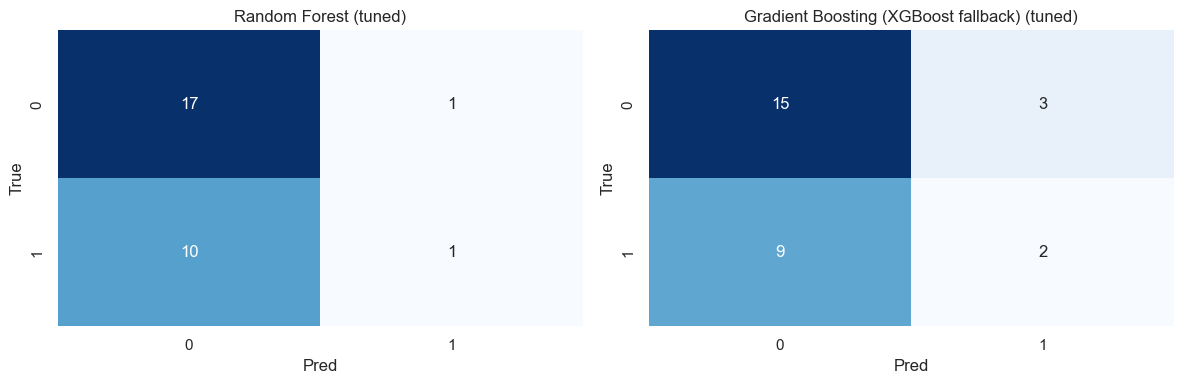

In [68]:
fig,ax=plt.subplots(1,len(models),figsize=(6*len(models),4))
if len(models)==1: ax=[ax]
for a,(n,m) in zip(ax,trained.items()):
    cm=confusion_matrix(y_test,(y_prob(m,X_test_sel)>=0.5).astype(int))
    sns.heatmap(cm,annot=True,fmt='d',cbar=False,cmap='Blues',ax=a)
    a.set_title(n); a.set_xlabel('Pred'); a.set_ylabel('True')
plt.tight_layout(); plt.show()


## 6. Statistical Evaluation (paired tests on CV scores)


In [69]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=SEED)
sc = {'auc_roc':'roc_auc','f1':'f1','pr_auc':'average_precision','precision':'precision','recall':'recall','accuracy':'accuracy'}
cv_rows=[]
for n,m in models.items():
    s=cross_validate(clone(m),X_train_sel,y_train,cv=cv,scoring=sc,n_jobs=1)
    d=pd.DataFrame({k:s[f'test_{k}'] for k in sc})
    d['model']=n
    cv_rows.append(d)
cv_df=pd.concat(cv_rows,ignore_index=True)
display(cv_df.groupby('model')[list(sc.keys())].agg(['mean','std']).round(4))


auc_roc              f1          \
                                                mean     std    mean     std   
model                                                                          
Gradient Boosting (XGBoost fallback) (tuned)  0.5077  0.1052  0.2872  0.1434   
Random Forest (tuned)                         0.5308  0.1333  0.1246  0.1211   

                                              pr_auc         precision  \
                                                mean     std      mean   
model                                                                    
Gradient Boosting (XGBoost fallback) (tuned)  0.4302  0.1000    0.3398   
Random Forest (tuned)                         0.4508  0.1158    0.3300   

                                                      recall         accuracy  \
                                                 std    mean     std     mean   
model                                                                           
Gradient Boosting (XGBoost fallback) (tuned)  0.2111  0.2706  0.1502   0.5433   
Random Forest (tuned)                         0.3668  0.0822  0.0835   0.6023   

                                                      
                                                 std  
model                                                 
Gradient Boosting (XGBoost fallback) (tuned)  0.0790  
Random Forest (tuned)                         0.0729

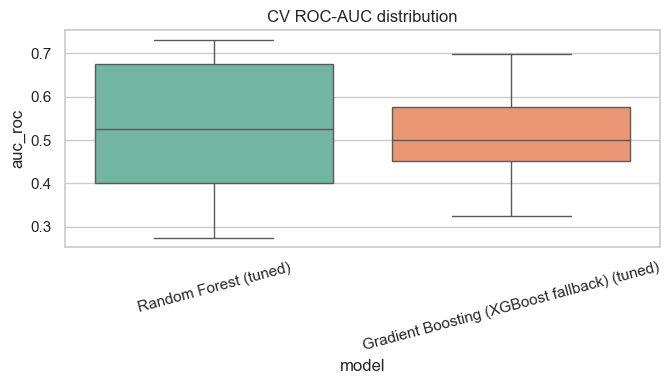

In [70]:
plt.figure(figsize=(7,4))
sns.boxplot(data=cv_df,x='model',y='auc_roc',palette='Set2')
plt.title('CV ROC-AUC distribution'); plt.xticks(rotation=15)
plt.tight_layout(); plt.show()


In [71]:
names=cv_df['model'].unique().tolist()
rows=[]
for metric in ['auc_roc','f1','pr_auc','precision','recall','accuracy']:
    for i in range(len(names)):
        for j in range(i+1,len(names)):
            a,b=names[i],names[j]
            x=cv_df.loc[cv_df.model==a,metric].to_numpy()
            yv=cv_df.loc[cv_df.model==b,metric].to_numpy()
            try: p_w=wilcoxon(x,yv).pvalue
            except ValueError: p_w=np.nan
            rows.append({'metric':metric,'model_a':a,'model_b':b,'mean_a':x.mean(),'mean_b':yv.mean(),'p_ttest':ttest_rel(x,yv).pvalue,'p_wilcoxon':p_w})
model_tests=pd.DataFrame(rows)
model_tests['p_ttest_fdr']=multipletests(model_tests.p_ttest,method='fdr_bh')[1]
model_tests['p_ttest_bonf']=multipletests(model_tests.p_ttest,method='bonferroni')[1]
wv=model_tests.p_wilcoxon.fillna(1.0)
model_tests['p_wilcoxon_fdr']=multipletests(wv,method='fdr_bh')[1]
model_tests['p_wilcoxon_bonf']=multipletests(wv,method='bonferroni')[1]
display(model_tests.round(4))


,metric,model_a,model_b,mean_a,mean_b,p_ttest,p_wilcoxon,p_ttest_fdr,p_ttest_bonf,p_wilcoxon_fdr,p_wilcoxon_bonf
0,auc_roc,Random Forest (tuned),Gradient Boosting (XGBoost fallback) (tuned),0.5308,0.5077,0.3413,0.2473,0.4096,1.0000,0.3709,1.0000
1,f1,Random Forest (tuned),Gradient Boosting (XGBoost fallback) (tuned),0.1246,0.2872,0.0001,0.0004,0.0002,0.0004,0.0012,0.0024
2,pr_auc,Random Forest (tuned),Gradient Boosting (XGBoost fallback) (tuned),0.4508,0.4302,0.2950,0.3123,0.4096,1.0000,0.3748,1.0000
3,precision,Random Forest (tuned),Gradient Boosting (XGBoost fallback) (tuned),0.3300,0.3398,0.9116,0.7263,0.9116,1.0000,0.7263,1.0000
4,recall,Random Forest (tuned),Gradient Boosting (XGBoost fallback) (tuned),0.0822,0.2706,0.0000,0.0001,0.0000,0.0000,0.0003,0.0003
5,accuracy,Random Forest (tuned),Gradient Boosting (XGBoost fallback) (tuned),0.6023,0.5433,0.0026,0.0031,0.0051,0.0154,0.0062,0.0185


## 7. Differential Taxa + Multiple Testing (FDR/Bonferroni)


In [72]:
is_t2d = y.loc[X_full_species.index]==1
rows=[]
for tax in X_full_species.columns:
    a=X_full_species.loc[is_t2d,tax]
    b=X_full_species.loc[~is_t2d,tax]
    rows.append({'taxon':tax,'effect_mean_t2d_minus_non':a.mean()-b.mean(),'p_mwu':mannwhitneyu(a,b,alternative='two-sided').pvalue,'p_ttest':ttest_ind(a,b,equal_var=False).pvalue})
taxa_df=pd.DataFrame(rows)
taxa_df['q_fdr_mwu']=multipletests(taxa_df.p_mwu,method='fdr_bh')[1]
taxa_df['p_bonf_mwu']=multipletests(taxa_df.p_mwu,method='bonferroni')[1]
taxa_df['q_fdr_ttest']=multipletests(taxa_df.p_ttest,method='fdr_bh')[1]
taxa_df['p_bonf_ttest']=multipletests(taxa_df.p_ttest,method='bonferroni')[1]
taxa_rank=taxa_df.sort_values('q_fdr_mwu').reset_index(drop=True)
display(taxa_rank.head(20).round(5))
print('FDR<0.05 taxa (MWU):', int((taxa_df.q_fdr_mwu<0.05).sum()))
print('Bonf<0.05 taxa (MWU):', int((taxa_df.p_bonf_mwu<0.05).sum()))


,taxon,effect_mean_t2d_minus_non,p_mwu,p_ttest,q_fdr_mwu,p_bonf_mwu,q_fdr_ttest,p_bonf_ttest
0,species:Roseburia sp. CAG:182,-0.03987,0.00177,0.14301,0.29866,0.36923,0.71574,1.0
1,genus:Streptococcus,0.00473,0.00286,0.12721,0.29866,0.59733,0.70550,1.0
2,species:Streptococcus mutans,0.03903,0.00451,0.04797,0.31400,0.94199,0.62262,1.0
3,species:Alistipes inops,-0.06596,0.01426,0.15359,0.37731,1.00000,0.71574,1.0
4,species:Alistipes shahii,-0.06853,0.01403,0.00689,0.37731,1.00000,0.62262,1.0
5,species:Clostridium sp. CAG:167,-0.03450,0.01128,0.31969,0.37731,1.00000,0.79795,1.0
6,species:Alistipes finegoldii,-0.12266,0.01444,0.05515,0.37731,1.00000,0.62262,1.0
7,species:Blautia wexlerae,0.19257,0.01205,0.02660,0.37731,1.00000,0.62262,1.0
8,species:Eubacterium sp. CAG:274,-0.06572,0.02124,0.05935,0.39014,1.00000,0.62262,1.0
9,species:Bacteroides cellulosilyticus,-0.15458,0.01893,0.04344,0.39014,1.00000,0.62262,1.0


FDR<0.05 taxa (MWU): 0
Bonf<0.05 taxa (MWU): 0


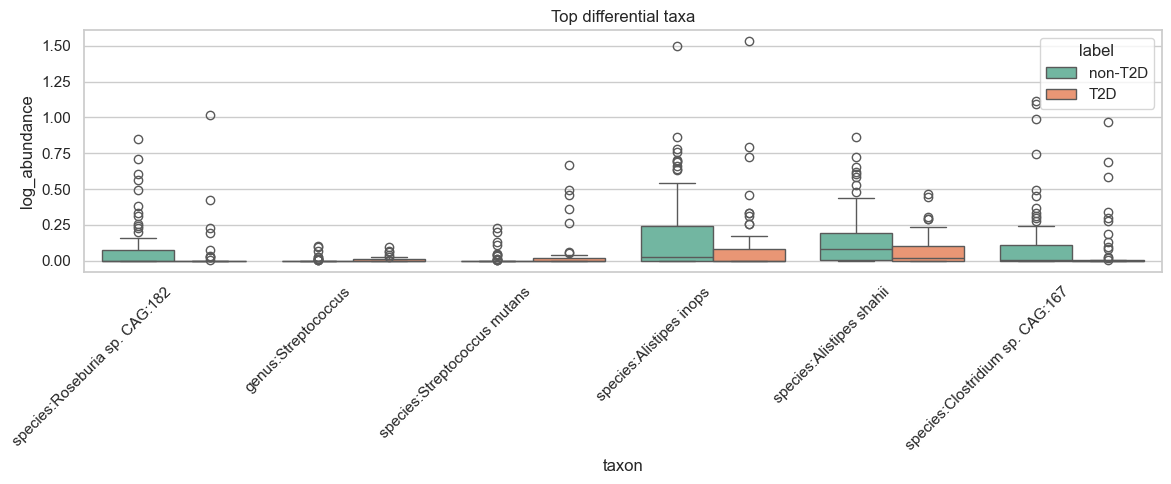

In [73]:
top=taxa_rank.head(6).taxon.tolist()
b=X_full_species[top].copy()
b['label']=np.where(y.loc[b.index]==1,'T2D','non-T2D')
long=b.melt(id_vars='label',var_name='taxon',value_name='log_abundance')
plt.figure(figsize=(12,5))
sns.boxplot(data=long,x='taxon',y='log_abundance',hue='label',palette='Set2')
plt.xticks(rotation=45,ha='right'); plt.title('Top differential taxa')
plt.tight_layout(); plt.show()


## 8. Explainability (Feature Importance + SHAP)


In [277]:
rf_exp = RandomForestClassifier(n_estimators=600,min_samples_leaf=2,class_weight='balanced',random_state=SEED)
rf_exp.fit(X_train_species,y_train)
imp = pd.Series(rf_exp.feature_importances_,index=X_train_species.columns).sort_values(ascending=False)
imp_df = imp.head(20).rename('importance').reset_index().rename(columns={'index':'taxon'})
display(imp_df.round(5))


,taxon,importance
0,species:Phocaeicola dorei,0.01757
1,species:Blautia wexlerae,0.01520
2,species:Alistipes putredinis,0.01469
3,species:Anaeromassilibacillus sp. An250,0.01444
4,species:Alistipes inops,0.01440
5,species:Streptococcus salivarius,0.01409
6,species:Clostridium sp. CAG:58,0.01326
7,species:Parabacteroides distasonis,0.01315
8,species:Firmicutes bacterium CAG:94,0.01313
9,species:Streptococcus parasanguinis,0.01312


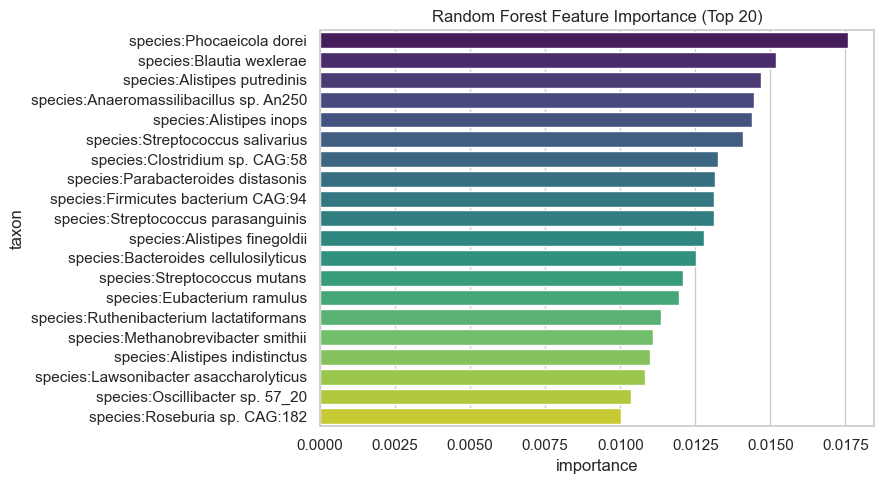

In [278]:
plt.figure(figsize=(9,5))
sns.barplot(data=imp_df,y='taxon',x='importance',palette='viridis')
plt.title('Random Forest Feature Importance (Top 20)')
plt.tight_layout(); plt.show()


In [279]:
expl = shap.TreeExplainer(rf_exp)
raw_sv = expl.shap_values(X_test_species, check_additivity=False)

if isinstance(raw_sv, list):
    # Older SHAP versions can return one array per class.
    sv = raw_sv[1] if len(raw_sv) > 1 else raw_sv[0]
else:
    sv = np.asarray(raw_sv)
    if sv.ndim == 3:
        # Newer SHAP can return a 3D tensor including class dimension.
        if sv.shape[1] == X_test_species.shape[1]:
            class_idx = 1 if sv.shape[2] > 1 else 0
            sv = sv[:, :, class_idx]
        elif sv.shape[2] == X_test_species.shape[1]:
            class_idx = 1 if sv.shape[0] > 1 else 0
            sv = sv[class_idx, :, :]
        else:
            raise ValueError(f"Unexpected SHAP shape {sv.shape} for {X_test_species.shape[1]} features")
    elif sv.ndim != 2:
        raise ValueError(f"Unexpected SHAP ndim: {sv.ndim}")

if sv.shape[1] != X_test_species.shape[1]:
    raise ValueError(f"SHAP feature mismatch: got {sv.shape[1]}, expected {X_test_species.shape[1]}")

sh = (
    pd.DataFrame(
        {
            'taxon': X_test_species.columns,
            'mean_abs_shap': np.abs(sv).mean(axis=0),
        }
    )
    .sort_values('mean_abs_shap', ascending=False)
    .head(20)
)
display(sh.round(5))


,taxon,mean_abs_shap
30,species:Alistipes inops,0.01383
33,species:Phocaeicola dorei,0.01164
203,species:Streptococcus mutans,0.01048
100,species:Bacteroides cellulosilyticus,0.00927
112,species:Alistipes indistinctus,0.00887
43,species:Streptococcus salivarius,0.00879
50,species:Parabacteroides distasonis,0.00852
129,species:Methanobrevibacter smithii,0.00776
16,species:Alistipes putredinis,0.00748
47,species:Alistipes finegoldii,0.00747


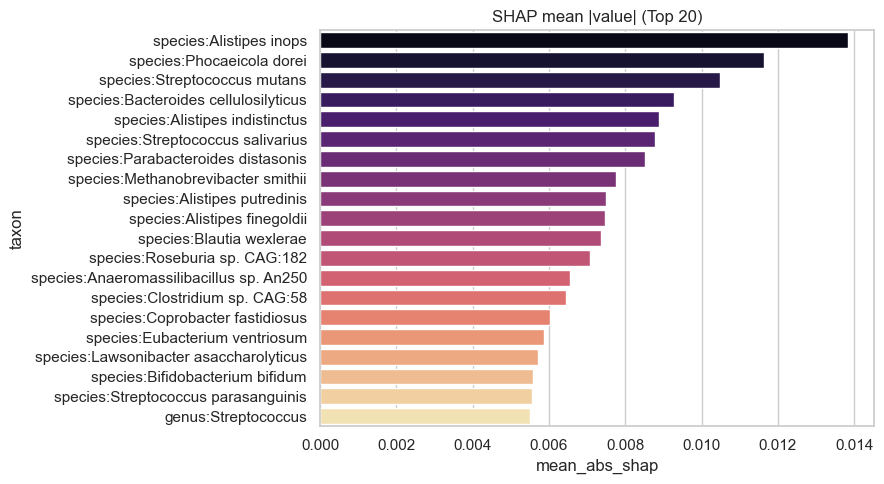

In [280]:
plt.figure(figsize=(9,5))
sns.barplot(data=sh,y='taxon',x='mean_abs_shap',palette='magma')
plt.title('SHAP mean |value| (Top 20)')
plt.tight_layout(); plt.show()


In [281]:
biomarkers = sh.merge(taxa_df[['taxon','effect_mean_t2d_minus_non','q_fdr_mwu']],on='taxon',how='left')
biomarkers['direction']=np.where(biomarkers.effect_mean_t2d_minus_non>=0,'higher in T2D','higher in non-T2D')
display(biomarkers.round(5))


,taxon,mean_abs_shap,effect_mean_t2d_minus_non,q_fdr_mwu,direction
0,species:Alistipes inops,0.01383,-0.06596,0.37731,higher in non-T2D
1,species:Phocaeicola dorei,0.01164,-0.14808,0.53851,higher in non-T2D
2,species:Streptococcus mutans,0.01048,0.03903,0.31400,higher in T2D
3,species:Bacteroides cellulosilyticus,0.00927,-0.15458,0.39014,higher in non-T2D
4,species:Alistipes indistinctus,0.00887,-0.03268,0.50858,higher in non-T2D
5,species:Streptococcus salivarius,0.00879,0.16308,0.62299,higher in T2D
6,species:Parabacteroides distasonis,0.00852,-0.10132,0.73447,higher in non-T2D
7,species:Methanobrevibacter smithii,0.00776,-0.25284,0.66863,higher in non-T2D
8,species:Alistipes putredinis,0.00748,-0.20515,0.59984,higher in non-T2D
9,species:Alistipes finegoldii,0.00747,-0.12266,0.37731,higher in non-T2D


## 9. Results and Discussion (paper structure)

### Results
- TAXA-level comparison is shown explicitly, and the selected level is justified from CV AUC.
- Model comparison is reported with ROC-AUC, PR-AUC, F1, Precision, Recall, and Accuracy.
- Statistical significance is tested with paired t-test and Wilcoxon, with FDR and Bonferroni corrections.
- Differential taxa analysis reports corrected p-values.
- Explainability combines feature importance with SHAP to highlight candidate biomarkers.

### Discussion
- In this dataset we only have species-level columns plus a few genus columns, so higher taxonomy levels are not directly testable without external mapping.
- The CNN result is included as a structure-aware baseline (species table reordered by taxonomy).
- Next steps are external validation and richer taxonomy annotation (Kingdom -> Family -> Genus).


## 9.1 Locked Run Summary
This cell gives one final, fixed summary for the current run so the key conclusion is clear in one place.


In [282]:
best_row = results_df.sort_values('auc_roc', ascending=False).iloc[0]

summary_table = pd.DataFrame([
    {
        'selected_taxa_level': best_level,
        'best_model': best_row['model'],
        'best_auc_roc': round(float(best_row['auc_roc']), 4),
        'best_pr_auc': round(float(best_row['pr_auc']), 4),
        'best_f1': round(float(best_row['f1']), 4),
    }
])

display(summary_table)
print('Locked takeaway: best test ROC-AUC model =', best_row['model'])


,selected_taxa_level,best_model,best_auc_roc,best_pr_auc,best_f1
0,species,Random Forest (tuned),0.6818,0.5174,0.1538


Locked takeaway: best test ROC-AUC model = Random Forest (tuned)


## 10. Results Kept In Notebook (No CSV Export)


In [283]:
print('No result CSV files are created. All results are displayed in this notebook.')

display(results_df.round(3))

display(
    cv_df.groupby('model')[['auc_roc','f1','pr_auc','precision','recall','accuracy']]
    .agg(['mean','std'])
    .round(4)
)

display(model_tests.round(4))
display(taxa_rank.head(20).round(5))


No result CSV files are created. All results are displayed in this notebook.


,model,representation,accuracy,auc_roc,f1,precision,recall,pr_auc
0,Random Forest (tuned),species,0.621,0.682,0.154,0.500,0.091,0.517
1,Gradient Boosting (XGBoost fallback) (tuned),species,0.586,0.657,0.250,0.400,0.182,0.508
2,Taxonomy-CNN,species->image(genus-ordered),0.414,0.404,0.414,0.333,0.545,0.403


auc_roc              f1          \
                                                mean     std    mean     std   
model                                                                          
Gradient Boosting (XGBoost fallback) (tuned)  0.5061  0.1043  0.2873  0.1436   
Random Forest (tuned)                         0.5308  0.1333  0.1246  0.1211   

                                              pr_auc         precision  \
                                                mean     std      mean   
model                                                                    
Gradient Boosting (XGBoost fallback) (tuned)  0.4287  0.0994    0.3284   
Random Forest (tuned)                         0.4508  0.1158    0.3300   

                                                      recall         accuracy  \
                                                 std    mean     std     mean   
model                                                                           
Gradient Boosting (XGBoost fallback) (tuned)  0.1749  0.2706  0.1502   0.5450   
Random Forest (tuned)                         0.3668  0.0822  0.0835   0.6023   

                                                      
                                                 std  
model                                                 
Gradient Boosting (XGBoost fallback) (tuned)  0.0697  
Random Forest (tuned)                         0.0729

,metric,model_a,model_b,mean_a,mean_b,p_ttest,p_wilcoxon,p_ttest_fdr,p_ttest_bonf,p_wilcoxon_fdr,p_wilcoxon_bonf
0,auc_roc,Random Forest (tuned),Gradient Boosting (XGBoost fallback) (tuned),0.5308,0.5061,0.3097,0.2158,0.3716,1.0000,0.3237,1.0000
1,f1,Random Forest (tuned),Gradient Boosting (XGBoost fallback) (tuned),0.1246,0.2873,0.0001,0.0004,0.0002,0.0003,0.0012,0.0024
2,pr_auc,Random Forest (tuned),Gradient Boosting (XGBoost fallback) (tuned),0.4508,0.4287,0.2671,0.2872,0.3716,1.0000,0.3447,1.0000
3,precision,Random Forest (tuned),Gradient Boosting (XGBoost fallback) (tuned),0.3300,0.3284,0.9848,0.7576,0.9848,1.0000,0.7576,1.0000
4,recall,Random Forest (tuned),Gradient Boosting (XGBoost fallback) (tuned),0.0822,0.2706,0.0000,0.0001,0.0000,0.0000,0.0003,0.0003
5,accuracy,Random Forest (tuned),Gradient Boosting (XGBoost fallback) (tuned),0.6023,0.5450,0.0018,0.0022,0.0036,0.0107,0.0044,0.0131


,taxon,effect_mean_t2d_minus_non,p_mwu,p_ttest,q_fdr_mwu,p_bonf_mwu,q_fdr_ttest,p_bonf_ttest
0,species:Roseburia sp. CAG:182,-0.03987,0.00177,0.14301,0.29866,0.36923,0.71574,1.0
1,genus:Streptococcus,0.00473,0.00286,0.12721,0.29866,0.59733,0.70550,1.0
2,species:Streptococcus mutans,0.03903,0.00451,0.04797,0.31400,0.94199,0.62262,1.0
3,species:Alistipes inops,-0.06596,0.01426,0.15359,0.37731,1.00000,0.71574,1.0
4,species:Alistipes shahii,-0.06853,0.01403,0.00689,0.37731,1.00000,0.62262,1.0
5,species:Clostridium sp. CAG:167,-0.03450,0.01128,0.31969,0.37731,1.00000,0.79795,1.0
6,species:Alistipes finegoldii,-0.12266,0.01444,0.05515,0.37731,1.00000,0.62262,1.0
7,species:Blautia wexlerae,0.19257,0.01205,0.02660,0.37731,1.00000,0.62262,1.0
8,species:Eubacterium sp. CAG:274,-0.06572,0.02124,0.05935,0.39014,1.00000,0.62262,1.0
9,species:Bacteroides cellulosilyticus,-0.15458,0.01893,0.04344,0.39014,1.00000,0.62262,1.0
